In [1]:
import numpy as np
import sys
sys.path.append('./ckplotlib/')
import map_funcs
from IPython.display import Image
#
import smoothlib
import xarray as xr
import geog_funcs

1.6.1


/Users/cdkoven/miniconda2/envs/jupyter/lib/python2.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/cdkoven/miniconda2/envs/jupyter/lib/python2.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
exps_list = ('ssp585','ssp534-over')
models_list = ('CanESM5','')
vars_list = ('tas','fgco2','nbp')
gridvars_list = ('areacella','areacello','sftlf','sftof')

nmodels = len(models_list) -1
nvars = len(vars_list)
nexps = len(exps_list)
ngridvars = len(gridvars_list)


file_master_list_dynamics = [[[[] for i in range(nexps )] for j in range(nvars)] for k in range(nmodels)]
### index this file as [model_i][var_i][exp_i]

file_master_list_grids = [[[] for j in range(ngridvars)] for k in range(nmodels)]
### index this file as [model_i][gridvar_i]

time_offset = [0,25]
nyears_total = 2300-2015+1


In [3]:
### load all the files for CanESM5

model_i = models_list.index('CanESM5')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = [
'tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc',
'tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc',
'tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2015-2100.nc',
'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2101-2180.nc',
'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2181-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = [
'nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc',
'nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc',
'nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = [
'tas_Amon_CanESM5_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'tas_Amon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = [
'fgco2_Oyr_CanESM5_ssp534-over_r1i1p1f1_gn_2040-2100.nc',
'fgco2_Oyr_CanESM5_ssp534-over_r1i1p1f1_gn_2101-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = [
'nbp_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'nbp_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc'
]

file_master_list_grids[model_i] = [
'areacella_fx_CanESM5_dcppA-hindcast_s1965-r7i1p2f1_gn.nc',
'areacello_Ofx_CanESM5_dcppA-hindcast_s1965-r7i1p2f1_gn.nc',
'sftlf_fx_CanESM5_dcppA-hindcast_s1965-r7i1p2f1_gn.nc',
'sftof_Ofx_CanESM5_dcppA-hindcast_s1965-r8i1p2f1_gn.nc'
]

In [4]:
### load tas for all models and calculate the global mean temperature trajectories
i_var = vars_list.index('tas')
tas_trajectories = []
for model_i in range(nmodels):
    print(models_list[model_i])
    tas_trajectories.append([])
    for exp_i in range(nexps):
        dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
        tasvar = dataset['tas'] - 273.15
        #print(tasvar.values)
        #tas_montyear = smoothlib.monthly_to_monthyear_xarray(tasvar)
        #print(tas_montyear)
        #tas_annual = smoothlib.monthly_to_annual_xarray(tasvar).compute()
        #print(tas_annual.values)
        #tas_annual_globalmean = geog_funcs.area_average(tas_annual.data[:], tasvar.coords['lat'].data[:], tasvar.coords['lon'].data[:])
        #tas_trajectories[model_i].append(tas_annual_globalmean)

CanESM5


In [5]:
### load the terrestrial NBP flux
i_var = vars_list.index('nbp')
nbp_trajectories = np.ma.masked_all([nmodels,nexps,nyears_total])
for model_i in range(nmodels):
    print(models_list[model_i])
    #
    # load landmask and land areas
    areavar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('areacella')])['areacella']
    #print(areavar)
    sftlfvar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('sftlf')])['sftlf']
    #print(sftlfvar)
    #
    for exp_i in range(nexps):
        dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
        nbpvar = dataset['nbp']
        print(nbpvar)
        global_nbp = (nbpvar * sftlfvar/100. * areavar).sum(dim="lat").sum(dim="lon") * 86400. * 365. * 1e3 * 1e-15
        global_nbp_annual = smoothlib.monthly_to_annual(global_nbp.values)
        nbp_trajectories[model_i,exp_i,time_offset[exp_i]:] = global_nbp_annual

CanESM5
<xarray.DataArray 'nbp' (time: 3432, lat: 64, lon: 128)>
dask.array<shape=(3432, 64, 128), dtype=float32, chunksize=(1032, 64, 128)>
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time     (time) object 2015-01-16 12:00:00 ... 2300-12-16 12:00:00
Attributes:
    standard_name:  surface_net_downward_mass_flux_of_carbon_dioxide_expresse...
    long_name:      Carbon Mass Flux out of Atmosphere Due to Net Biospheric ...
    comment:        up is changed to down! CFNB*12.011E-9, ScenarioMIP_table_...
    units:          kg m-2 s-1
    original_name:  CFNB
    cell_methods:   area: mean where land time: mean
    cell_measures:  area: areacella
<xarray.DataArray 'nbp' (time: 3132, lat: 64, lon: 128)>
dask.array<shape=(3132, 64, 128), dtype=float32, chunksize=(732, 64, 128)>
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85

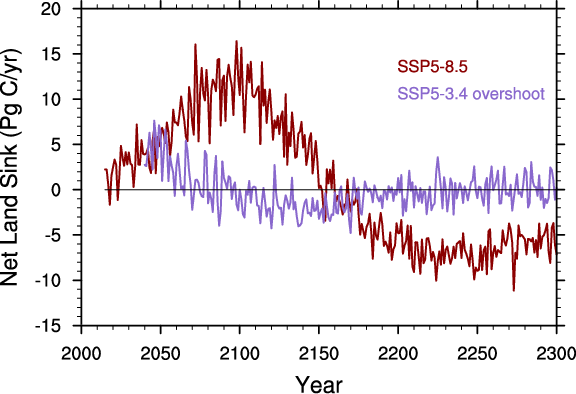

In [6]:
years = np.arange(nyears_total)+2015.
map_funcs.xyplot(years, nbp_trajectories[0,:,:], file='nbp_longterm', showjupyter=True,  png_dens=100, colors=['Red4','MediumPurple3'], labels=['SSP5-8.5','SSP5-3.4 overshoot'],xtitle='Year',ytitle='Net Land Sink (Pg C/yr)', label_xstart=2200, label_yspace=3, aspect_ratio=1.5, hline=0.)

In [7]:
### load the ocean fgco2 flux
i_var = vars_list.index('fgco2')
fgco2_trajectories = np.ma.masked_all([nmodels,nexps,nyears_total])
for model_i in range(nmodels):
    print(models_list[model_i])
    #
    # load landmask and land areas
    area_ocean_var = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('areacello')])['areacello']
    #print(areavar)
    sftofvar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('sftof')])['sftof']
    #print(sftlfvar)
    #
    for exp_i in range(nexps):
        dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
        fgco2var = dataset['fgco2']
        print(fgco2var)
        global_fgco2_annual = (fgco2var * sftofvar/100. * area_ocean_var).sum(dim="i").sum(dim="j") * 86400. * 365. * 1e3 * 1e-15
        fgco2_trajectories[model_i,exp_i,time_offset[exp_i]:] = global_fgco2_annual

CanESM5
<xarray.DataArray 'fgco2' (time: 286, j: 291, i: 360)>
dask.array<shape=(286, 291, 360), dtype=float32, chunksize=(86, 291, 360)>
Coordinates:
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 283 284 285 286 287 288 289 290
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 -78.39 -78.39 -78.39 -78.39 ... 50.51 50.23 50.01
    longitude  (j, i) float64 73.5 74.5 75.5 76.5 ... 72.93 72.95 72.96 72.99
  * time       (time) object 2015-07-02 12:00:00 ... 2300-07-02 12:00:00
Attributes:
    standard_name:  surface_downward_mass_flux_of_carbon_dioxide_expressed_as...
    long_name:      Surface Downward Flux of Total CO2
    comment:        Gas exchange flux of CO2 (positive into ocean)
    units:          kg m-2 s-1
    original_name:  Cflx
    history:        meanm2y_mltby0.012
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
<xarray.DataArray 'fgco2' (time: 261, j: 291, i: 360)>
dask.ar

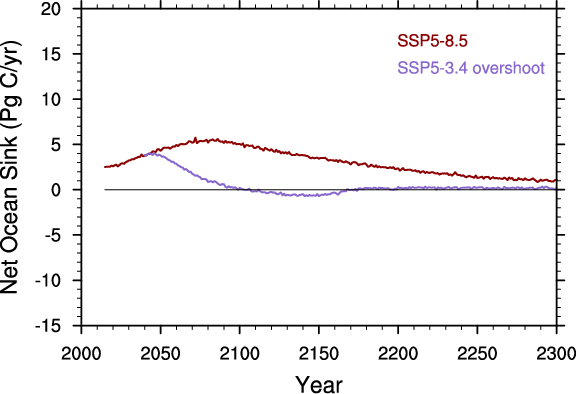

In [8]:
map_funcs.xyplot(years, fgco2_trajectories[0,:,:], file='fgco2_longterm', showjupyter=True,  png_dens=100, colors=['Red4','MediumPurple3'], labels=['SSP5-8.5','SSP5-3.4 overshoot'],xtitle='Year',ytitle='Net Ocean Sink (Pg C/yr)', label_xstart=2200, label_yspace=3, aspect_ratio=1.5, hline=0., yrange=[-15.,20.])
